In [6]:
!pip install -qqq torchmetrics pytorch-lightning segmentation-models-pytorch

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

from pytorch_lightning.loggers import WandbLogger

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp

from pprint import pprint

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

In [8]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0


def get_data_path():
    data_path = []
    for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
        try:
            dir_name = sub_dir_path.split('/')[-1]
            for filename in os.listdir(sub_dir_path):
                mask_path = sub_dir_path + '/' + filename
                data_path.extend([dir_name, mask_path])
        except Exception as e:
            print(e)
    return data_path


def load_data():
    data_path = get_data_path()
            
    filenames = data_path[::2]
    masks = data_path[1::2]

    df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})

    original_img = df[~df['img_path'].str.contains("mask")]
    mask_img = df[df['img_path'].str.contains("mask")]

    imgs = sorted(original_img["img_path"].values, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    masks = sorted(mask_img["img_path"].values, key=lambda x: int(x.split("_")[-2].split(".")[0]))

    mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                               'mask_path':masks})

    mri_df['mask'] = mri_df['mask_path'].apply(get_diagnosis)
    mri_df['mask_path'] = mri_df['mask_path'].astype("str")
    mri_df.drop(columns=['patient_id'], inplace=True)    
    return mri_df

In [9]:
mri_df = load_data()

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


## Visualization

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


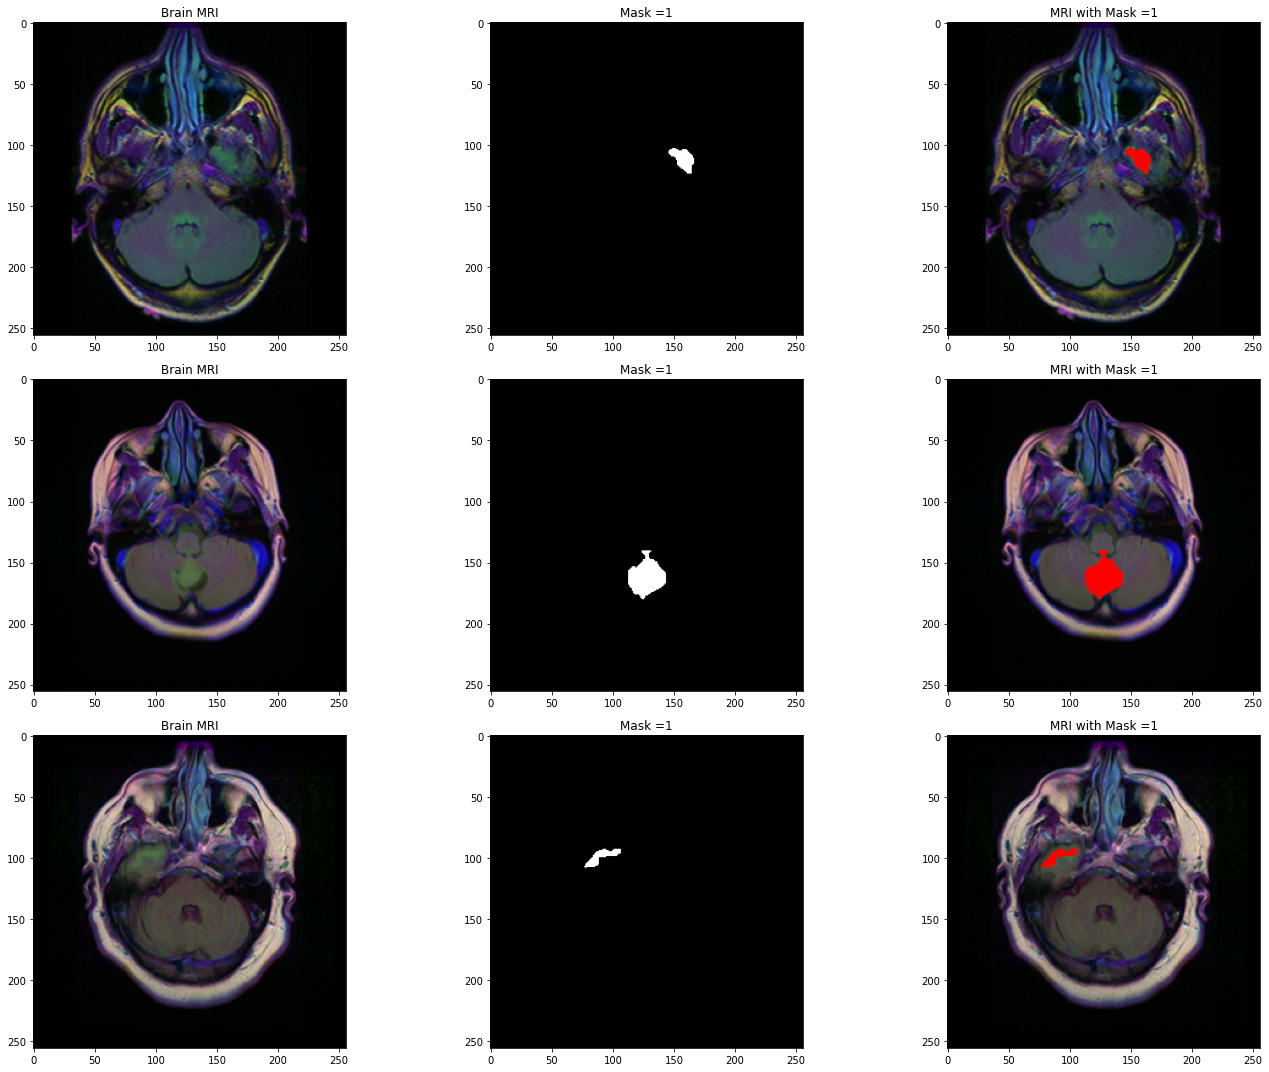

In [10]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        print(img.shape)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

## Dataset & Dataloader

In [11]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [12]:
preprocess_input = smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet')

def adjust_data(img, mask):
#     img = img / 255.
    img = preprocess_input(img)
    mask = mask / 255.
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    
    return (img, mask)

In [13]:
class MyDataset(Dataset):
    def __init__(
            self,
            df=mri_df, 
            adjust_data=adjust_data, 
            image_transform=image_transform,
            mask_transform=mask_transform
        ):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data= adjust_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
#         mask =cv2.imread(mask_path, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#         _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        image, mask = self.adjust_data(image, mask)

        if self.image_transform:
            image = self.image_transform(image).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

In [14]:
# index = 2911
# data = MyDataset()[index]
# data[0].shape, data[1].shape

# plt.imshow(data[0].permute(1, 2, 0).numpy())

# plt.imshow(data[1].permute(1, 2, 0).squeeze(-1).numpy())

In [15]:
def prepare_loaders(df=mri_df,
                    train_num=int(mri_df.shape[0] * .6), 
                    valid_num=int(mri_df.shape[0] * .8), 
                    batch_size=32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num: valid_num].reset_index(drop=True)    
    test = df[valid_num:].reset_index(drop=True)

    train_ds = MyDataset(df=train)
    valid_ds = MyDataset(df=valid)
    test_ds = MyDataset(df=test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=4, num_workers=os.cpu_count(), shuffle=True)
    
    print("DataLoader Completed")
    
    return train_loader, valid_loader, test_loader

In [16]:
train_loader, valid_loader, test_loader = prepare_loaders(df=mri_df,
                                                          train_num=int(mri_df.shape[0] * .65), 
                                                          valid_num=int(mri_df.shape[0] * .85), 
                                                          batch_size=32)

DataLoader Completed


## Model

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [18]:
class UNETModel(pl.LightningModule):

    def __init__(self,):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
        )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def _step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        assert mask.ndim == 4

        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def _epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        total_loss = 0
        iter_count = len(outputs)
    
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        metrics = {
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self._epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self._epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self._epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## Train

In [19]:
model = UNETModel()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
pl.seed_everything(2022)

2022

In [21]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


checkpoint_callback = ModelCheckpoint(
    monitor="valid_f1_score",
    mode='max',
    filename= "model_best",
    dirpath ='./',
    save_top_k = 1,
    save_weights_only=True
)

early_stop = EarlyStopping(monitor="valid_f1_score", min_delta=0.00, patience=20, verbose=True, mode="max")

In [22]:
from pytorch_lightning.loggers import CSVLogger

trainer = pl.Trainer(
    logger=CSVLogger(save_dir=f"logs/"),
    gpus=-1, 
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop]
)

In [23]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Evaluation

In [24]:
check_path = '/kaggle/working/model_best.ckpt'
check_path

'/kaggle/working/model_best.ckpt'

In [25]:
model.load_from_checkpoint(check_path);

In [26]:
valid_metrics = trainer.validate(model, dataloaders=valid_loader,  ckpt_path=check_path, verbose=True)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      valid_accuracy       │    0.9968675374984741     │
│     valid_dataset_iou     │    0.7852804660797119     │
│      valid_f1_score       │     0.879727840423584     │
│        valid_loss         │    0.14823760092258453    │
│    valid_per_image_iou    │    0.8369362950325012     │
│      valid_precision      │    0.8944127559661865     │
│       valid_recall        │    0.8655173778533936     │
└───────────────────────────┴───────────────────────────┘

In [27]:
test_metrics = trainer.test(model, dataloaders=test_loader, ckpt_path=check_path, verbose=True)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9979903101921082     │
│     test_dataset_iou      │    0.7025933861732483     │
│       test_f1_score       │      0.8253213763237      │
│         test_loss         │    0.24865971505641937    │
│    test_per_image_iou     │    0.8647425174713135     │
│      test_precision       │    0.8856505751609802     │
│        test_recall        │    0.7726870775222778     │
└───────────────────────────┴───────────────────────────┘

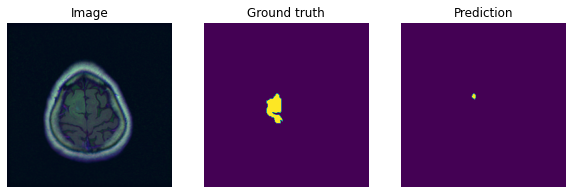

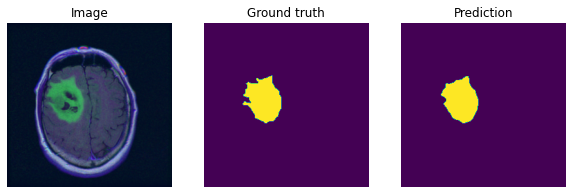

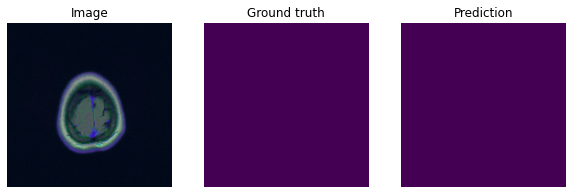

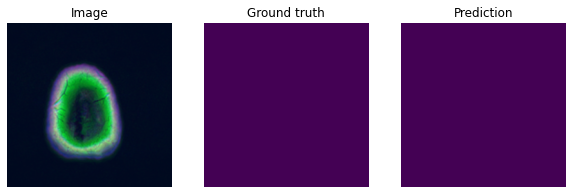

In [45]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])

pr_masks = (logits > 0).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    image = image.detach().cpu().numpy().transpose(1, 2, 0)  # convert CHW -> HWC
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [61]:
metrics = metrics.filter(like="valid").dropna().join(metrics.filter(like="train").dropna())
metrics.columns = pd.MultiIndex.from_tuples(x.split("_", 1)[::-1] for x in metrics.columns)

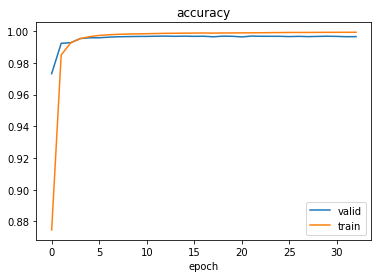

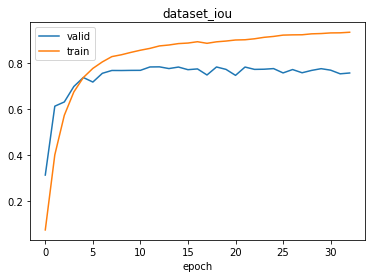

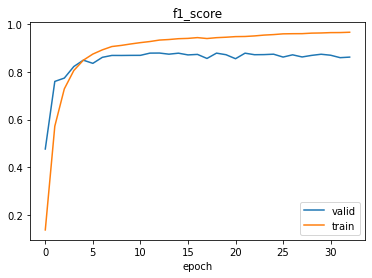

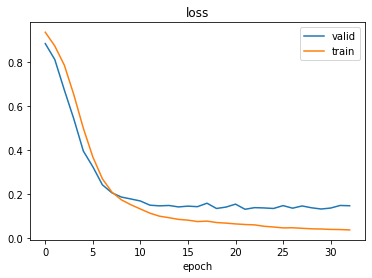

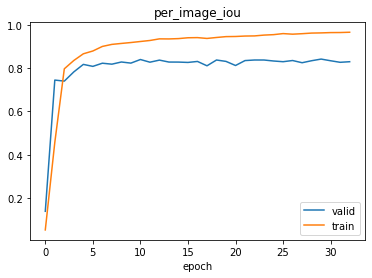

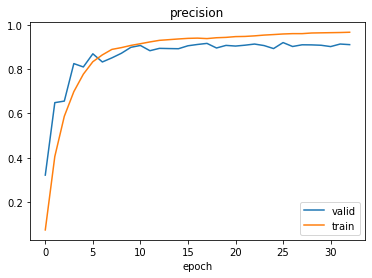

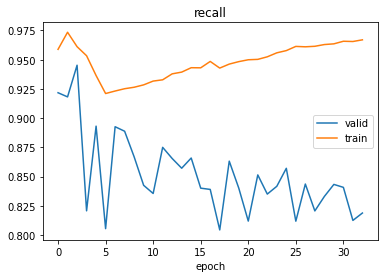

In [77]:
for x in metrics.columns.levels[0]:
    metrics[x].plot(title=x)